In [14]:
import tensorflow as tf
from tensorflow.python.keras import backend as K
config = tf.compat.v1.ConfigProto( device_count = {'GPU': 1 , 'CPU': 8} )
sess = tf.compat.v1.Session(config=config) 
K.set_session(sess)

In [15]:
tf.test.is_built_with_cuda()

True

In [16]:
from keras.datasets import imdb
import numpy as np
from keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense
from tensorflow.keras import initializers
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from keras.datasets import imdb
from numpy.random import seed
seed(5)
import tensorflow
tensorflow.random.set_seed(180)

## Using RNNs to classify sentiment on IMDB data

In this assignment,you will train three types of RNNs:  "vanilla" RNN, LSTM and GRU to predict the sentiment on IMDB reviews.  

Keras provides a convenient interface to load the data and immediately encode the words into integers (based on the most common words). 
This will save you a lot of the drudgery that is usually involved when working with raw text.

The IMDB is  data consists of 25000 training sequences and 25000 test sequences. 
The outcome is binary (positive/negative) and both outcomes are equally represented in both the training and the test set.


Walk through the followinng steps to prepare the data and the building of an RNN model. 

1- Use the `imdb.load_data()` to load in the data 

2- Specify the maximum length of a sequence to 20000 words and the pick the most common words to 30. 

In [17]:
def dataload(num_words=20000):
    (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=num_words)
    return train_data,train_labels,test_data, test_labels
train_data,train_labels,test_data, test_labels= dataload(num_words=20000)

3- Check that the number of sequences in train and test datasets are equal (default split):
    
Expected output:
- `x_train = 25000 train sequences`

- `x_test = 25000 test sequences`

In [18]:
np.size(train_data) , np.size(test_data)

(25000, 25000)

4- Pad (or truncate) the sequences so that they are of the maximum length

In [19]:
 def padd(train_data,test_data,train_labels,test_labels):
    x_train=sequence.pad_sequences(train_data,common_words)
    x_test=sequence.pad_sequences(test_data,common_words)
    y_train = np.asarray(train_labels).astype('float32').reshape((-1,1))
    y_test = np.asarray(test_labels).astype('float32').reshape((-1,1))
    return x_train,x_test,y_train,y_test
common_words=30
x_train,x_test,y_train,y_test=padd(train_data,test_data,train_labels,test_labels)
x_train.shape

(25000, 30)

5- After padding or truncating, check the dimensionality of x_train and x_test.

Expected output:
- `x_train shape: (25000, 30)`
- `x_test shape: (25000, 30)`

In [20]:
print('x_train shape:',x_train.shape)
print('x_test shape:',x_test.shape)

x_train shape: (25000, 30)
x_test shape: (25000, 30)


## Keras layers for (Vanilla) RNNs

In this step, you will not use pre-trained word vectors, Instead you will learn an embedding as part of the  the Vanilla) RNNs network  Neural Network. 

In the Keras API documentation, the Embedding Layer and the SimpleRNN Layer have the following syntax:

### Embedding Layer
`keras.layers.embeddings.Embedding(input_dim, output_dim, embeddings_initializer='uniform', embeddings_regularizer=None, activity_regularizer=None, embeddings_constraint=None, mask_zero=False, input_length=None)`

- This layer maps each integer into a distinct (dense) word vector of length `output_dim`.
- Can think of this as learning a word vector embedding "on the fly" rather than using an existing mapping (like GloVe)
- The `input_dim` should be the size of the vocabulary.
- The `input_length` specifies the length of the sequences that the network expects.

### SimpleRNN Layer
`keras.layers.recurrent.SimpleRNN(units, activation='tanh', use_bias=True, kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal', bias_initializer='zeros', kernel_regularizer=None, recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0, recurrent_dropout=0.0)`

- This is the basic RNN, where the output is also fed back as the "hidden state" to the next iteration.
- The parameter `units` gives the dimensionality of the output (and therefore the hidden state).  Note that typically there will be another layer after the RNN mapping the (RNN) output to the network output.  So we should think of this value as the desired dimensionality of the hidden state and not necessarily the desired output of the network.
- Recall that there are two sets of weights, one for the "recurrent" phase and the other for the "kernel" phase.  These can be configured separately in terms of their initialization, regularization, etc.






6- Build the RNN with three layers: 
- The SimpleRNN layer with 5 neurons and initialize its kernel with stddev=0.001

- The Embedding layer and initialize it by setting the word embedding dimension to 50. This means that this layer takes each integer in the sequence and embeds it in a 50-dimensional vector.

-  The output layer has the sigmoid activation function.

In [21]:
def create_model(num_words=20000,inputlength=30,nl=1):
    model=Sequential()
    model.add(Embedding(num_words,50,input_length=inputlength))
    for i in range(nl):
        model.add(SimpleRNN(5,return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.01)))
    model.add(Dense(1,activation='sigmoid'))
    return model
model1=create_model(20000,30,1)
model1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 30, 50)            1000000   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 30, 5)             280       
                                                                 
 dense_3 (Dense)             (None, 30, 1)             6         
                                                                 
Total params: 1,000,286
Trainable params: 1,000,286
Non-trainable params: 0
_________________________________________________________________


7- How many parameters have the embedding layer?

#### The embedding layer has input_dim*output_dim number of parameters. Here the input dimension is 20000 as we truncated the sequence to maximum length of 20000, and output dimension or word embedding dimension as 50. Therefore it is 50 times 20000=  1000000 

8 - Train the network with the RMSprop with learning rate of .0001 and epochs=10 

9 -  PLot the loss and accuracy metrics during the training and interpret the result.

In [22]:
from sklearn import metrics
def plot_loss(loss,val_loss):
  plt.figure()
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'val'], loc='upper right')
  plt.show()
def plot_accuracy(acc,val_acc):
  # Plot training & validation accuracy values
  plt.figure()
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'val'], loc='upper left')
  plt.show()

 ## loss and accuracy metrics during the training 

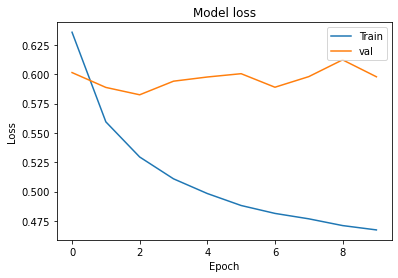

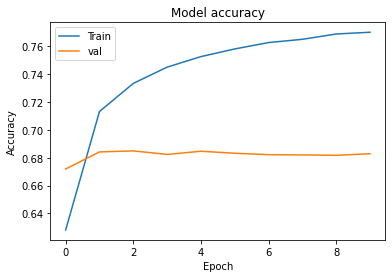

1min 31s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [23]:
%%timeit -n1 -r1 
rms=RMSprop(learning_rate=0.001)
model1.compile(optimizer=rms,loss='binary_crossentropy',metrics=['acc'])
history1=model1.fit(x_train,y_train,epochs=10,batch_size=32,validation_split = 0.2,verbose=0)
plot_loss(history1.history['loss'], history1.history['val_loss'])
# Plot train vs test accuracy during training
plot_accuracy(history1.history['acc'], history1.history['val_acc'])

### As seen the loss and accuracy wrt to validation and test shows a lot of variation (sudden highs and lows). It is possible that this variation is reduced by increasing the number of epoches/hidden layers. We will be also tuning the maxlenght and num_words to see the changes.
### model took 25s per loop

10- Check the accuracy and the loss of your models on the test dataset.

In [24]:
results = model1.evaluate(x_train, y_train,verbose=0)
print("train loss, train acc:", results)
results = model1.evaluate(x_test, y_test,verbose=0)
print("test loss, test acc:", results)

train loss, train acc: [0.4791858494281769, 0.7629373669624329]
test loss, test acc: [0.6023980379104614, 0.6804251670837402]


### Base model gives 76% train and 68% test accuracy

## Tuning The Vanilla RNN Network


11- Prepare the data to use sequences of length 80 rather than length 30 and retrain your model.  Did it improve the performance?

12- Try different values of the  maximum length of a sequence ("max_features").  Can you improve the performance?

13- Try smaller and larger sizes of the RNN hidden dimension.  How does it affect the model performance?  How does it affect the run time?

## 11 lets tune the sequence of lenght to 80

In [25]:
train_data,train_labels,test_data, test_labels= dataload(num_words=20000)
common_words=80
x_train,x_test,y_train,y_test=padd(train_data,test_data,train_labels,test_labels)
x_train.shape

(25000, 80)

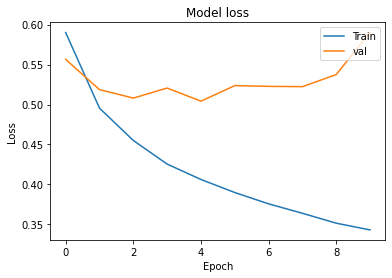

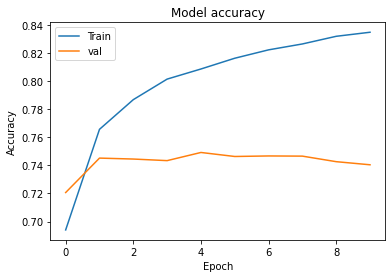

train loss, train acc: [0.36964860558509827, 0.8274429440498352]
test loss, test acc: [0.6292873620986938, 0.721177875995636]
3min 57s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [26]:
%%timeit -n1 -r1 
model2=create_model(20000,80,1)
rms=RMSprop(learning_rate=0.001)
model2.compile(optimizer=rms,loss='binary_crossentropy',metrics=['acc'])
history2=model2.fit(x_train,y_train,epochs=10,batch_size=32,validation_split = 0.2,verbose=0)
plot_loss(history2.history['loss'], history2.history['val_loss'])
# Plot train vs test accuracy during training
plot_accuracy(history2.history['acc'], history2.history['val_acc'])
results = model2.evaluate(x_train, y_train,verbose=0)
print("train loss, train acc:", results)
results = model2.evaluate(x_test, y_test,verbose=0)
print("test loss, test acc:", results)

### AS we can see that the model accuracy and loss had a slightly lesser variation than base model. The train and test accuracy are now 81% and 72% (which is a significant increase from the base model). Hence increasing the lenght of sequences did increase the accuracy. Though the runtime increased to 51s per loop

## 12.1 max_length tuning to 50k from 20k

In [27]:
train_data,train_labels,test_data, test_labels= dataload(num_words=50000)
common_words=80
x_train,x_test,y_train,y_test=padd(train_data,test_data,train_labels,test_labels)
x_train.shape

(25000, 80)

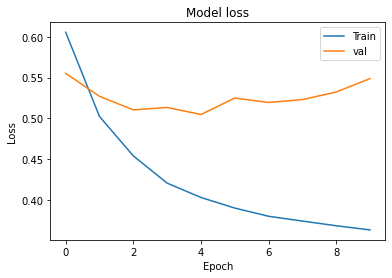

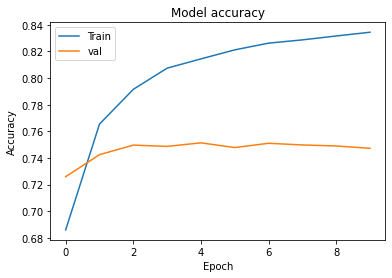

train loss, train acc: [0.38406190276145935, 0.8264749050140381]
test loss, test acc: [0.5952852368354797, 0.7200760245323181]
4min 6s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [28]:
%%timeit -n1 -r1 
model3=create_model(50000,80,1)
rms=RMSprop(learning_rate=0.001)
model3.compile(optimizer=rms,loss='binary_crossentropy',metrics=['acc'])
history3=model3.fit(x_train,y_train,epochs=10,batch_size=32,validation_split = 0.2,verbose=0)
plot_loss(history3.history['loss'], history3.history['val_loss'])
# Plot train vs test accuracy during training
plot_accuracy(history3.history['acc'], history3.history['val_acc'])
results = model3.evaluate(x_train, y_train,verbose=0)
print("train loss, train acc:", results)
results = model3.evaluate(x_test, y_test,verbose=0)
print("test loss, test acc:", results)

###  The train and test accuracy are now 82% and 72% (which is a same accuracy as the previous model). Hence increasing the max length of sequence from 20k to 50k maintained almost  similar accuracy. THough the runtime slightly increased to 1m6s per loop

## 12.2 max_length tuning to 5k from 50k

In [29]:
train_data,train_labels,test_data, test_labels= dataload(num_words=5000)
common_words=80
x_train,x_test,y_train,y_test=padd(train_data,test_data,train_labels,test_labels)
x_train.shape

(25000, 80)

In [ ]:
%%timeit -n1 -r1 
model4=create_model(5000,80,1)
rms=RMSprop(learning_rate=0.001)
model4.compile(optimizer=rms,loss='binary_crossentropy',metrics=['acc'])
history4=model4.fit(x_train,y_train,epochs=10,batch_size=32,validation_split = 0.2,verbose=0)
plot_loss(history4.history['loss'], history4.history['val_loss'])
# Plot train vs test accuracy during training
plot_accuracy(history4.history['acc'], history4.history['val_acc'])
results = model4.evaluate(x_train, y_train,verbose=0)
print("train loss, train acc:", results)
results = model4.evaluate(x_test, y_test,verbose=0)
print("test loss, test acc:", results)

###  The train and test accuracy are now 78% and 72% (which is a same test accuracy as the previous model). Hence decreasing the max length of sequence from 5k from 50k maintained almost  similar test accuracy. Though the runtime decreased to 48s per loop

## 13.1 using 2 RNN hidden dimension

In [ ]:
train_data,train_labels,test_data, test_labels= dataload(num_words=5000)
common_words=80
x_train,x_test,y_train,y_test=padd(train_data,test_data,train_labels,test_labels)
x_train.shape

In [ ]:
%%timeit -n1 -r1 
model5=Sequential()
model5.add(Embedding(5000,50,input_length=80))
model5.add(SimpleRNN(2,return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.01)))
model5.add(Dense(1,activation='sigmoid'))
rms=RMSprop(learning_rate=0.001)
model5.compile(optimizer=rms,loss='binary_crossentropy',metrics=['acc'])
history5=model5.fit(x_train,y_train,epochs=10,batch_size=32,validation_split = 0.2,verbose=0)
plot_loss(history5.history['loss'], history5.history['val_loss'])
# Plot train vs test accuracy during training
plot_accuracy(history5.history['acc'], history5.history['val_acc'])
results = model5.evaluate(x_train, y_train,verbose=0)
print("train loss, train acc:", results)
results = model5.evaluate(x_test, y_test,verbose=0)
print("test loss, test acc:", results)

### As we can see using 2 RNN hidden dimensions the accuracy of train and test became 78.7% and 72.7% respectively (which is almost same as the previous model).
### Though the runtime for model training is now 46.5s ,which is slightly lesser than of  the previous value

## 13.2 using 16 RNN hidden dimension

In [ ]:
train_data,train_labels,test_data, test_labels= dataload(num_words=5000)
common_words=80
x_train,x_test,y_train,y_test=padd(train_data,test_data,train_labels,test_labels)
x_train.shape

In [ ]:
%%timeit -n1 -r1 
model6=Sequential()
model6.add(Embedding(5000,50,input_length=80))
model6.add(SimpleRNN(16,return_sequences=True, kernel_initializer=initializers.RandomNormal(stddev=0.01)))
model6.add(Dense(1,activation='sigmoid'))
rms=RMSprop(learning_rate=0.001)
model6.compile(optimizer=rms,loss='binary_crossentropy',metrics=['acc'])
history6=model6.fit(x_train,y_train,epochs=10,batch_size=32,validation_split = 0.2,verbose=0)
plot_loss(history6.history['loss'], history6.history['val_loss'])
# Plot train vs test accuracy during training
plot_accuracy(history6.history['acc'], history6.history['val_acc'])
results = model6.evaluate(x_train, y_train,verbose=0)
print("train loss, train acc:", results)
results = model6.evaluate(x_test, y_test,verbose=0)
print("test loss, test acc:", results)

### As we can see using 16 RNN hidden dimensions the accuracy of train and test became 79% and 72% respectively (which is almost same as the previous model). 
### Though the runtime for model training is now 47s ,which is almost same as the previous model

## Train LSTM and GRU networks


14- Build LSTM and GRU networks and compare their performance (accuracy and execution time) with the SimpleRNN. What is your conclusion?

In [ ]:
%%timeit -n1 -r1
from keras.layers import LSTM
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 20000)
x_train = sequence.pad_sequences(x_train, maxlen = 30)
x_test = sequence.pad_sequences(x_test, maxlen = 30)

model = Sequential()
model.add(Embedding(20000, 50, input_length = 30))
model.add(LSTM(5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001),loss = 'binary_crossentropy',metrics = ['acc'])

lstm_ = model.fit(x_train,y_train,epochs = 10,validation_split = 0.2,verbose=0)
plot_loss(lstm_.history['loss'], lstm_.history['val_loss'])
# Plot train vs test accuracy during training
plot_accuracy(lstm_.history['acc'], lstm_.history['val_acc'])
results = model.evaluate(x_train, y_train,verbose=0)
print("train loss, train acc:", results)
results = model.evaluate(x_test, y_test,verbose=0)
print("test loss, test acc:", results)

### As we can see the accuracy and loss graph wrt to epoches does not have much variance as compared to before. The training and test accuracies are 83% and 77.6% each (which is 9% more test accuracy than the base model).
### the runtime is 39s per loop as compared to 25s of base model

## GRU

In [ ]:
%%timeit -n1 -r1
from keras.layers import GRU
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words = 20000)
x_train = sequence.pad_sequences(x_train, maxlen = 30)
x_test = sequence.pad_sequences(x_test, maxlen = 30)

model = Sequential()
model.add(Embedding(20000, 50, input_length = 30))
model.add(GRU(5, activation = 'relu',dropout = 0.1, recurrent_dropout = 0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.0001),loss = 'binary_crossentropy',metrics = ['acc'])

gru_ = model.fit(x_train,y_train,epochs = 10,validation_split = 0.2,verbose=0)
plot_loss(gru_.history['loss'], gru_.history['val_loss'])
# Plot train vs test accuracy during training
plot_accuracy(gru_.history['acc'], gru_.history['val_acc'])
results = model.evaluate(x_train, y_train,verbose=0)
print("train loss, train acc:", results)
results = model.evaluate(x_test, y_test,verbose=0)
print("test loss, test acc:", results)

### As we can see the accuracy and loss graph wrt to epoches does not have much variance as compared to before. The training and test accuracies are 74.1% and 70.4% each (which is 2% more than the base model).
### the runtime is 1m 6s per loop as compared to 25s of base model
### Both models will further improve with more number of epoches as both the train and val accuracy and loss have not converged. 

# From the above models we can conclude that LSTM model gives good accuracy but the runtime is largern than SimpleRNN. 
## We also observed that increasing the sequence of length also helps in increasing the accuracy to a great exent.
